### Simple lasagne seqGAN

Here we train a simple recurrent GAN through gumbel-softmax trick.

### Loading the data

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'axes.titlesize': 'small'})
import numpy as np

#wget the data
!wget https://raw.githubusercontent.com/yandexdataschool/HSE_deeplearning/master/week4/names -O names &> log

In [2]:
START = " " #all phrases will start with this token
END = ";"   #end token. MUST be unique! (no phrase must contain it otherwise)
PAD = "_"   #token used to make all phrases of equal length.

with open("names") as f:
    data = f.read()[:-1].split('\n')
    data = np.array([START+name+END for name in data])


#all unique characters go here
from collections import Counter
tokens = Counter([PAD,START,END])
for sample in data:
    tokens.update(sample)

tokens = list(tokens)
n_tokens = len(tokens)
token_to_i = {l:i for i,l in enumerate(tokens)}
print 'n_tokens = ',len(tokens)

n_tokens =  57


In [3]:
def as_matrix(sequences, max_len=None,dtype='int8'):
    """convert strings to a matrix of tokens, pad with PAD.
    :param max_len: matrix width. If None, infers from the LONGEST phrase"""
    max_len = max_len or max(map(len,sequences))
    matrix = np.zeros((len(sequences),max_len),dtype=dtype) +token_to_i[PAD]
    for i,seq in enumerate(sequences):
        row_ix = map(token_to_i.get,seq)[:max_len]
        matrix[i,:len(row_ix)] = row_ix
    
    return matrix

In [4]:
batch = data[np.random.randint(0,len(data),5)]
print batch
print as_matrix(batch)

[' Ebony;' ' Kam;' ' Brunhilda;' ' Theobald;' ' Alaine;']
[[ 0  7 33 44 45 54  3 30 30 30 30]
 [ 0 13 31 42  3 30 30 30 30 30 30]
 [ 0  6 49 50 45 39 38 43 35 31  3]
 [ 0 24 39 34 44 33 31 43 35  3 30]
 [ 0  4 43 31 38 45 34  3 30 30 30]]


### Blah-blah GAN
Blah-blah gumbel blah-blah architecture

In [6]:
%env THEANO_FLAGS=device=gpu7,floatX=float32
import theano
import theano.tensor as T

gumbel_t = theano.shared(np.float32(1.)) #temperature for gumbel-softmax


env: THEANO_FLAGS=device=gpu7,floatX=float32


Using gpu device 7: GeForce GTX 1080 (CNMeM is enabled with initial size: 45.0% of memory, cuDNN 5105)


In [7]:
from gumbel_softmax import GumbelSoftmax

class real_data:

    inputX = T.matrix('input_sequences', 'int32') # [batch_size, length]
    
    X_flat = inputX.ravel()
    X_one_hot = T.extra_ops.to_one_hot(X_flat,n_tokens)
    X_gumbel = GumbelSoftmax(gumbel_t)(X_one_hot*10)    
    
    output_gumbel = X_gumbel.reshape(tuple(inputX.shape)+(n_tokens,))
    
    output_mask = T.neq(inputX,token_to_i[PAD])
    

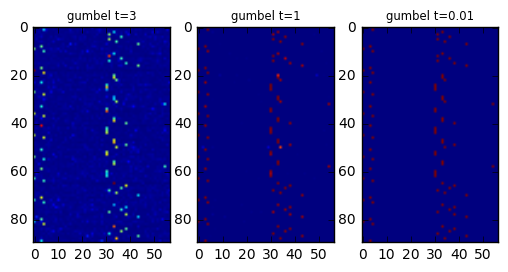

In [8]:
plt.subplot(1,3,1)
plt.title('gumbel t=3')
gumbel_t.set_value(3)
plt.imshow(real_data.output_gumbel.eval({real_data.inputX:as_matrix(data[:10])}).reshape(-1,n_tokens))

plt.subplot(1,3,2)
plt.title('gumbel t=1')
gumbel_t.set_value(1)
plt.imshow(real_data.output_gumbel.eval({real_data.inputX:as_matrix(data[:10])}).reshape(-1,n_tokens))

plt.subplot(1,3,3)
plt.title('gumbel t=0.01')
gumbel_t.set_value(0.01)
plt.imshow(real_data.output_gumbel.eval({real_data.inputX:as_matrix(data[:10])}).reshape(-1,n_tokens))
gumbel_t.set_value(1)


In [62]:
import lasagne
from lasagne.layers import *
from agentnet import Recurrence
from agentnet.memory import *

def get_mask(output_tokens):
    """takes matrix of real or generated tokens,
    returns mask with '1's only until the first 'end' (inclusively)"""
    assert output_tokens.ndim==2
    is_end = T.eq(output_tokens,token_to_i[END]).astype('int32')
    
    cumsum_end = T.concatenate([
            T.zeros_like(is_end[:,:1]),
            T.cumsum(is_end,axis=-1)[:,:-1]
            ],axis=-1)
    return T.eq(cumsum_end,0)

class generator:
    inputZ = T.matrix('input_noise', 'float32')

    NUM_UNITS = 256 #generator RNN size
    CODE_SIZE = 128 # size of uniform noise
    n_steps = T.iscalar("n_steps for generator")

    #####NOISE#####
    l_in = InputLayer((None, CODE_SIZE), input_var=inputZ,
                      name='g_input_noise')
    l_rnn_init = DenseLayer(l_in,NUM_UNITS,nonlinearity=T.tanh,
                            name = "gru initial state from noize")
    l_each_tick = DenseLayer(l_in,25,nonlinearity=T.tanh,
                            name = "gru additional input from noize")
    
    
    #####STEP#####
    l_input = InputLayer((None,n_tokens))
    l_input_argmax = ExpressionLayer(l_input,lambda a: a.argmax(-1),(None,))
    l_input_emb = EmbeddingLayer(l_input_argmax,n_tokens,30)

    l_code = InputLayer((None,25))
    
    l_prev_rnn = InputLayer((None,NUM_UNITS))
    l_new_rnn = GRUCell(l_prev_rnn,[l_input_emb,l_code])
    
    
    
    l_pre_out = DenseLayer(l_new_rnn,len(tokens),
                         nonlinearity=None)
    
    
    l_probas = NonlinearityLayer(l_pre_out,
                         nonlinearity=T.nnet.softmax)
    
    
    l_gumbel = NonlinearityLayer(l_pre_out,
                         nonlinearity=GumbelSoftmax(gumbel_t))
    
    
    feedback_loop = Recurrence(
        state_variables={
            l_new_rnn:l_prev_rnn,
            l_gumbel:l_input
        },
        state_init={l_new_rnn:l_rnn_init},
        input_nonsequences={l_code:l_each_tick},
        tracked_outputs=[l_gumbel,l_probas],
        unroll_scan=False,
        n_steps = n_steps
    )
    l_gen = feedback_loop[l_gumbel]
    l_prob = feedback_loop[l_probas]
    
    assert len(l_gen.output_shape)==3 and l_gen.output_shape[-1] == len(tokens)

    weights = get_all_params(l_gen, trainable=True)
    
    ###outputs
    output_gumbel,output_probas = get_output([l_gen,l_prob])
    output_tokens = T.argmax(output_gumbel,axis=-1)
    output_mask = get_mask(output_tokens)
    rng_updates = feedback_loop.get_automatic_updates()
    
    sample = theano.function([inputZ,n_steps],[output_tokens,output_mask],updates=rng_updates)
    sample_probas = theano.function([inputZ,n_steps],[output_gumbel, output_mask],updates=rng_updates)
    
    
    @staticmethod
    def generate(noise=None,max_len=25):
        #make noise
        noise = noise or np.random.randn(1,generator.CODE_SIZE).astype('float32')
        #sample indices
        answer_ix,mask = generator.sample(noise,max_len)
        answer_ix = answer_ix[0,mask[0]]
        return ''.join(map(tokens.__getitem__, answer_ix))

/home/hedgedir/agentnet/agentnet/agent/recurrence.py:188: UserWarning: State_variables recommended type is OrderedDict.
                Otherwise, order of agent state outputs from get_sessions and get_agent_reaction methods
                may depend on python configuration.

                Current order is: [<lasagne.layers.merge.ElemwiseMergeLayer object at 0x7fb7fc4fb310>, <lasagne.layers.special.NonlinearityLayer object at 0x7fb7fc4fb910>]
                You may find OrderedDict in standard collections module: from collections import OrderedDict
                
  """.format(state_variables=list(self.state_variables.keys())))


In [128]:
generator.generate(max_len=50)

' C;'

### Discriminator

Here your work begins :)

In [64]:
from lasagne.nonlinearities import *
from lasagne.init import Normal
from lasagne.layers import *


class discriminator:
    ##########
    #TODO:
    # - make this guy take gumbel sequence as input [None,None,n_tokens]
    # - make this guy output single probability at the end
    # - do not forget to apply MASK to the RNN
    # --- create an input layer for mask.
    # - pairs of inputs:
    # --- fake images: generator.output_gumbel,generator.output_mask
    # --- real images: real_data.output_gumbel,real_data.output_mask
    # - use pure lasagne for now (keep it simple)
    NUM_UNITS=128
    
        
    seq_in = InputLayer((None, None, n_tokens),real_data.output_gumbel,name='d_input')
    mask_in = InputLayer((None, None),real_data.output_mask, name='d_input_mask')

    lstm_1 = LSTMLayer(seq_in,NUM_UNITS,mask_input=mask_in, 
                            nonlinearity=T.tanh,)

    l_logit = DenseLayer(lstm_1,1,nonlinearity=None,num_leading_axes=2) #P(real|x)
    l_prob = NonlinearityLayer(l_logit,sigmoid)
    
    
    weights = get_all_params(l_prob, trainable=True)
    
    predict = theano.function([real_data.inputX],get_output(l_prob)[:,-1])


In [77]:
randomness = theano.shared(1e-5, name="randomness")

In [78]:
class training:
    
    #D(data). Uses default inputs from real_data.*
    p_real_is_real,logit_real = get_output([discriminator.l_prob,discriminator.l_logit])
    
    #D(G(z))    
    p_gen_is_real,logit_gen = get_output([discriminator.l_prob,discriminator.l_logit],
                                           {discriminator.seq_in: generator.output_gumbel,
                                            discriminator.mask_in: generator.output_mask})
    

    
    
    #negative entropy of G
    g_n_entropy = (T.log(generator.output_probas)* generator.output_mask[:,:,None]).sum() / generator.output_probas.shape[0]
    
    ########################
    ###generator training###
    ########################
    
    
    g_loss = - g_n_entropy * randomness - T.log(p_gen_is_real).mean()
    g_updates = lasagne.updates.adagrad(g_loss, generator.weights, 0.005)
    g_train_step = theano.function([generator.inputZ, generator.n_steps], 
                                   [g_loss, generator.output_probas],
                                   updates=g_updates+generator.rng_updates)

    
    ########################
    #discriminator training#
    ########################
    
    
    d_loss = -T.log(p_real_is_real).mean() - T.log(1-p_gen_is_real).mean()

    #regularize for pre-sigmoid activations
    d_loss += 0.01*(T.mean(logit_real**2) + T.mean(logit_gen**2))

    d_updates = lasagne.updates.adagrad(d_loss, discriminator.weights, 0.005)
    d_train_step = theano.function([real_data.inputX, generator.inputZ, generator.n_steps],
                                   d_loss, updates=d_updates+generator.rng_updates)
    

### Auxilary functions
Sampling, visualization

In [79]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, generator.CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return as_matrix(data[idxs])

def sample_text(n_texts,max_len=25):
    return [generator.generate(max_len=max_len) for _ in xrange(n_texts)]

def sample_probas(bsize,max_len=25):
    
    real_batch = sample_data_batch(bsize)
    D_on_real_data = discriminator.predict(real_batch).ravel()
    
    gen_batch = as_matrix(sample_text(bsize,max_len=max_len))
    D_on_gen = discriminator.predict(gen_batch).ravel()
    
    plt.hist(D_on_real_data,label='D(x)', alpha=0.5)
    plt.hist(D_on_gen,label='D(G(z))',alpha=0.5)
    plt.legend(loc='best')
    plt.xlim(0,1)
    plt.show()

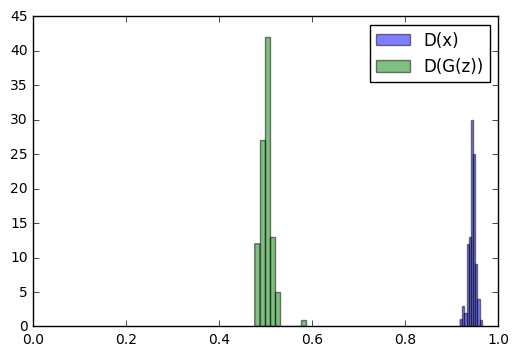

In [80]:
sample_probas(100, True)

### Training

In [141]:
gumbel_t.set_value(3.0)
randomness.set_value(1e-5)

In [ ]:
from IPython import display
from tqdm import tqdm

probs = None
for epoch in tqdm(xrange(100000)):
    for i in range(3):
        d_loss = training.d_train_step(sample_data_batch(100), sample_noise_batch(100), 25)
    for i in range(1):
        g_loss, probs = training.g_train_step(sample_noise_batch(100),25)
        
        
    gumbel_t.set_value((gumbel_t.get_value()*(1-0.0001)).astype("float32"))

    if epoch %100==0:
        display.clear_output(wait=True)
        print sample_text(5)
        sample_probas(1000)
    if epoch%25==0:
        print 'D_loss=%.3f,G_loss=%.3f,gumbel_t=%.3f'%(d_loss,g_loss,gumbel_t.get_value())
        

[" HJVApq'DWCBMP-JqQAr-YRbn", "CMdlMgNwSepIrxBdcTY'Kzymi", '_cvFGu_AxDlgFlZdrtPgNEzq-', ' tfaVohwQdXqFUaPrtav  ooc', " nPFUjl-s'RVVGspEhgQWSSnQ"]


In [137]:
probs

array([[[  5.18527210e-01,   7.02320272e-03,   6.63515134e-03, ...,
           5.87685639e-03,   9.19082575e-03,   9.12074000e-03],
        [  3.97856813e-03,   1.51654184e-02,   1.56066213e-02, ...,
           1.54008958e-02,   1.60031635e-02,   1.93495844e-02],
        [  3.02088185e-04,   1.72109734e-02,   1.18530123e-02, ...,
           1.52019272e-02,   1.44948401e-02,   1.76824927e-02],
        ..., 
        [  2.98754836e-04,   1.87279806e-02,   1.91573631e-02, ...,
           1.92216374e-02,   1.61834266e-02,   2.03722119e-02],
        [  3.96667607e-03,   2.04449445e-02,   1.81877259e-02, ...,
           1.62880011e-02,   1.84668675e-02,   2.10380554e-02],
        [  1.64722987e-02,   1.98336560e-02,   1.72689278e-02, ...,
           1.47829205e-02,   1.84403099e-02,   1.91202108e-02]],

       [[  7.45931208e-01,   6.85368013e-03,   5.15978178e-03, ...,
           4.60288720e-03,   5.21052862e-03,   3.79285333e-03],
        [  7.54713314e-03,   2.21969821e-02,   2.07819361e-0